목표: 80%정도의 정확도를 VGG와 ResNet을 이용해서 90%이상으로 끌어올려보자.

진행순서 <br>
Step1: 실험환경 Set-up <br>
    -  Batch size, Epoch등을 변경 <br>
Step2: 데이터 준비하기 <br>
    - 원본 데이터를 가져와서 전처리 및 배치 구성을 진행 <br>
    - 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않다 => Data Augment기법 고려 (<-- 항상 도움이 되는 건 아니지만..) <br>
Step3: 데이터 시각화 <br>
    - 학습용 데이터 시각화 <br> 
Step4: ResMet-18구현 <br> 
    - Convolution filter,채널 개수, activation, 모델 구조등을 다양하게 바꿀 수 있음 <br>
    - 1. 3*3 CNN <br>
    - 2. BatchNormalization <br>
    - 3. 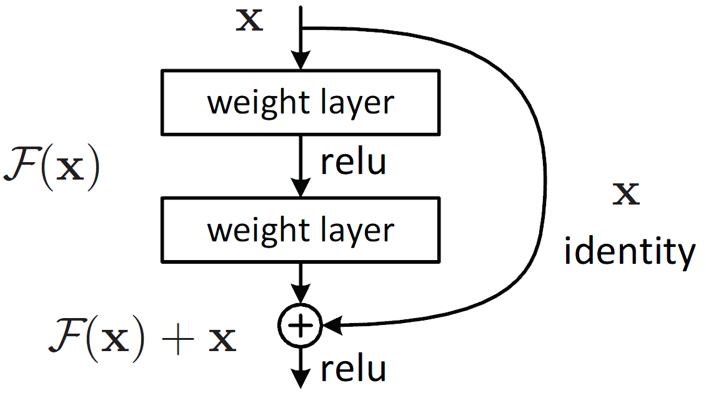 <br>
Step5: 데이터 imbalance 처리 <br>
Step6: 모델 훈련 <br>
    - optimizer나 learning rate등의 변화를 고려할 수 있음 <br>
Step7: 결과 확인과 시각화 <br>
    - accuracy뿐만 아니라 recall도 <br>
    - 훈련과정의 history도 그래프로 시각화 <br>
    - 학습진행 양상을 분석 <br>

In [1]:
# 데이터셋 불러올용
import os, re
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd

# 데이터 시각화용
import matplotlib.pyplot as plt
import random, math

# 모델학습용
from tensorflow import keras
from tensorflow.keras import layers, backend, regularizers, initializers, models, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Layer, Add
from keras.models import Sequential
#use categorical_crossentropy since the label is one-hot encoded
from tensorflow.keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
from keras.callbacks import EarlyStopping

import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
os.getcwd()

'/aiffel/aiffel/workplace/Aiffel_Quest/MainQuest'

In [3]:
# data_path = os.getenv("HOME")+'/aiffel/workplace/Aiffel_Quest/MainQuest/chest-xray-pneumonia/train'

### Step1. 실험환경 Set-up

In [4]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [360, 360]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경, 기존 코드와는 다르게 변경함
BATCH_SIZE = 24
EPOCHS = 50


print(ROOT_PATH)

/aiffel/aiffel


In [5]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0838-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person363_bacteria_1655.jpeg


### Step2. 데이터 준비하기

In [8]:
train_data = image_dataset_from_directory(
            ROOT_PATH+'/chest_xray/data/train/',
            batch_size = BATCH_SIZE,
            image_size = IMAGE_SIZE,
            label_mode='binary'
)

test_data = image_dataset_from_directory(
            ROOT_PATH+'/chest_xray/data/test/',
            batch_size = BATCH_SIZE,
            image_size = IMAGE_SIZE,
            label_mode='binary'
)

val_data = image_dataset_from_directory(
            ROOT_PATH+'/chest_xray/data/val/',
            batch_size = BATCH_SIZE,
            image_size = IMAGE_SIZE,
            label_mode='binary'
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


<BatchDataset shapes: ((None, 360, 360, 3), (None, 1)), types: (tf.float32, tf.float32)>


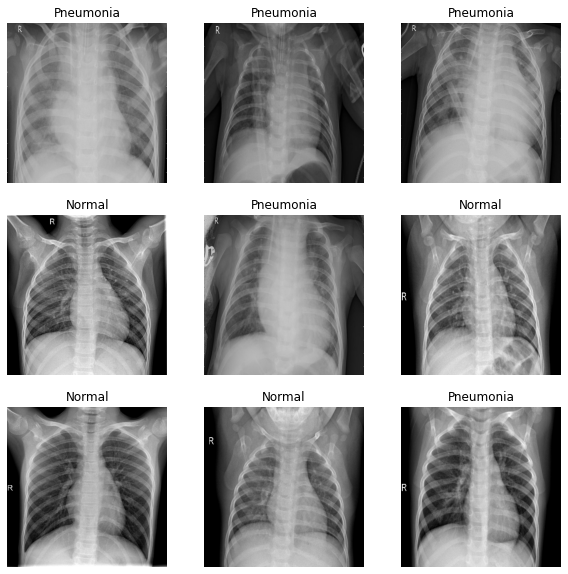

In [9]:
# 이미지 데이터셋이 잘 호출됐는지 확인용
print(train_data)
class_names = ['Normal', 'Pneumonia']

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [10]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [11]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [13]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [14]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

print(train_ds)
print(val_ds)

<ParallelMapDataset shapes: ((360, 360, 3), ()), types: (tf.float32, tf.bool)>
<ParallelMapDataset shapes: ((360, 360, 3), ()), types: (tf.float32, tf.bool)>


In [16]:
# 2-1에 있던 코드, 데이터를 augment함
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전.
    return image,label

# 이 방법도 이따 model 학습때 사용해볼것
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.1, 0.1)
])


def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds2 = prepare_for_training(train_ds)
val_ds2 = prepare_for_training(val_ds)

print(train_ds2)
print(val_ds2)

<PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.bool)>


### Step3. 데이터 시각화

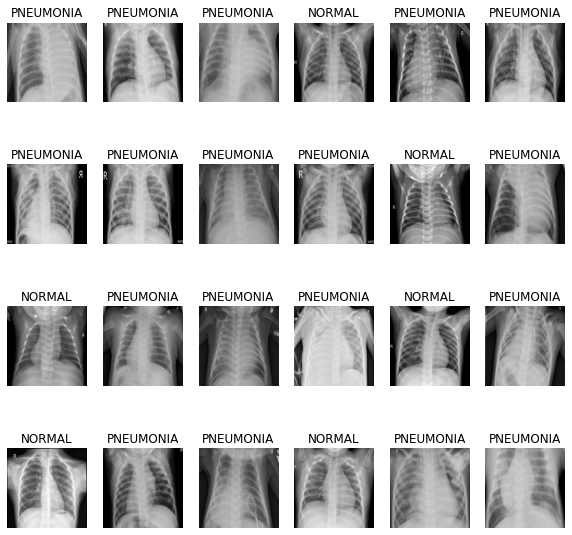

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
# training 이전에 데이터 시각화 해보기
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds2))
show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
print(label_batch.numpy())

[ True  True  True False  True  True  True  True  True  True False  True
 False  True  True  True False  True False  True  True False  True  True]


### Step4. ResNet-18 구현

In [19]:
# 구글링3 - Kaggle
class ResnetBlock(Model):
    """A standard resnet block"""
    def __init__(self, channels: int, down_sample=False):
        """channels: same as number of convolution kernels"""
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [20]:
class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        """um_classes: number of classes in specific classification task."""
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

### Step5. 데이터 imbalance처리

weight말고 recall을 늘리려면..?

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [24]:
# 이 방법은 뭘까..
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
over_x,over_y = smote.fit_resample(X,y) # train_ds, val_ds하면 에러남

### Step6. 모델 훈련

In [30]:
resnet18 = ResNet18(100)
# a = tf.random.uniform(shape=(1,32,32,1))
# b = resnet18(a)
# # print(b)
resnet18.build(input_shape=(None, 180,180,3))

resnet18.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
resnet18.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           multiple                  9472      
_________________________________________________________________
batch_normalization_60 (Batc multiple                  256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
resnet_block_24 (ResnetBlock multiple                  74368     
_________________________________________________________________
resnet_block_25 (ResnetBlock multiple        

In [31]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    resnet18.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
es = EarlyStopping(monitor='loss', min_delta=0.0005, mode='auto', patience=2, verbose=1)

In [36]:
with tf.device('/GPU:0'):
    history = resnet18.fit(
        train_ds2,
        steps_per_epoch = BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        callbacks=[es]
    )

Epoch 1/50


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.9/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 100) vs (None, 1))


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')